## BLU06 - Learning Notebook - Part 3 of 3 - Advanced topics on ML for Time Series Forecasting

In [1]:
import pandas as pd 
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt 
from sklearn.ensemble import GradientBoostingRegressor
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
%matplotlib inline 
import numpy as np
plt.rcParams['figure.figsize'] = (16, 4)

import warnings
warnings.filterwarnings(action="ignore")
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

from utils import * # We've added all the functions from the last BLU to the utils.py 

# 1. Exogenous Features

We already learned how to use exogenous features for our SARIMAX models, but what about machine learning models? It's actually pretty straightforward! Let's look at the solar production dataset we looked at on the previous BLU.

In [2]:
df = pd.read_csv('data/pv.csv')
df.Datetime = pd.to_datetime(df.Datetime)
df = df.set_index('Datetime')
df = df.sort_index()

In [3]:
train = df['2016-01']
test = df['2016-02-01']

In [4]:
predictions = predict_n_periods(series_=train, 
                  n_periods=24, 
                  model=GradientBoostingRegressor(random_state=10, n_estimators=20), 
                  num_periods_lagged=5,
                  num_periods_diffed=0,
                  weekday = True,
                  month = True,
                  holidays = True,
                  target = "Power"
                  )
test_mae = mean_absolute_error(test[:24].Power,predictions)
print(test_mae)

  0%|          | 0/24 [00:00<?, ?it/s]

1960.5059208170405


<AxesSubplot:xlabel='Datetime'>

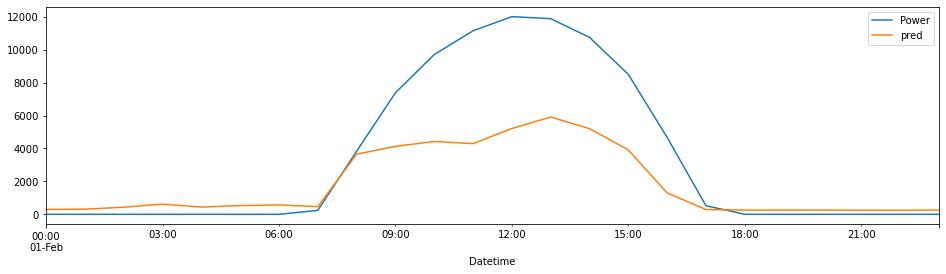

In [5]:
test["pred"] = predictions
test[["Power","pred"]].plot()

## 1.1 Adding exogenous features

Now let's load the exogenous feature data, which you might recall corresponds to a radiation forecast. 

In [6]:
exog = pd.read_csv('data/radiation.csv')
exog.Datetime = pd.to_datetime(exog.Datetime)
exog = exog.set_index('Datetime')
exog = exog.sort_index()

In [7]:
df["exog"] = exog.radiation

Remember that our exogenous data corresponds to a **forecast** and not measured values. This means that when we're performing the solar production forecast for tomorrow we have access to the solar irradiation forecast for tomorrow. Given that, similarly to how we create lags we now need to create leads for the exogenous variable. The function below will create 24 leads so that when performing the prediction the model has access to the irradiation forecast for the following 24 hours.

In [8]:
df = build_exog_features(df, 24)

In [9]:
train = df['2016-01']
test = df['2016-02-01']

In [10]:
predictions = predict_n_periods(series_=train, 
                  n_periods=24, 
                  model=GradientBoostingRegressor(random_state=10, n_estimators=20), 
                  num_periods_lagged=5,
                  num_periods_diffed=0,
                  weekday = True,
                  month = True,
                  holidays = True,
                  target = "Power"
                  )
test_mae = mean_absolute_error(test[:24].Power,predictions)
print(test_mae)

  0%|          | 0/24 [00:00<?, ?it/s]

556.5538969544173


Similarly to the SARIMAX models, the exogenous data very significantly improved model performance!

<AxesSubplot:xlabel='Datetime'>

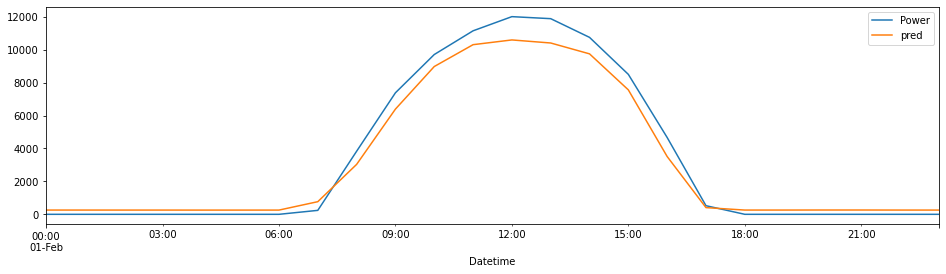

In [11]:
test["pred"] = predictions
test[["Power","pred"]].plot()

# 2. Time Series Cross Validation

First let's get the data into the cleaned form of the last notebook

In [12]:
store = get_store_data()
store['date'] = pd.to_datetime(store['date'], format='%Y-%m-%d')
store = store.set_index('date')
store = store.sort_index()

In [13]:
store_resampled = store.resample('D').mean()
store_cleaned = store_resampled.fillna(0)
#store_cleaned = store_cleaned.customers

In [14]:
test_split_date = '2017-6'
store_train = store_cleaned.loc[store_cleaned.index < test_split_date]
store_test = store_cleaned.loc[store_cleaned.index >= test_split_date]

Remember in the last BLU when we obtained a better score on the test set than on the validation set? Well, in fact the type of validation we were doing was quite simple, we were using only one fold. As you learned in the bootcamp, normally it's better to use more folds to get a better approximation of the test error.

So let's see what would happen if we used the KFold from sklearn:

## 2.1 K-Fold Cross Validation

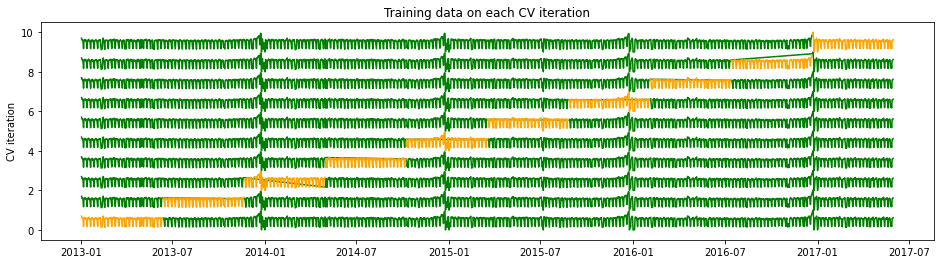

In [15]:
# Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

# Create time-series cross-validation object
cv = KFold(n_splits=10)

# Iterate through CV splits
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(store_train/store_train.max())):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(store_train.index[tr], ii + store_train.iloc[tr]/store_train.max(), color='green')
    ax.plot(store_train.index[tt], ii + store_train.iloc[tt]/store_train.max(), color='orange')

ax.set(title='Training data on each CV iteration', ylabel='CV iteration')
plt.show()

This plot shows for each split (yy axis) which data is used for training (green) and for testing (orange). But do you see the problem? In all cases, except for the last iteration on top, you'd be training with data from the future to predict the past. This is a clear case of data leakage. But there are better ways to perform time series cross validation.

## 2.2 Expanding Window

A better method for doing cross validation is using the _TimeSeriesSplit_ from sklearn. By default, it uses a window that expands with each fold, as can be seen on the plot below.yy There are several advantages to this method, for one it doesn't cause data leakage. But besides that, it also allows you to inspect how well the model generalizes to different parts of the time series.

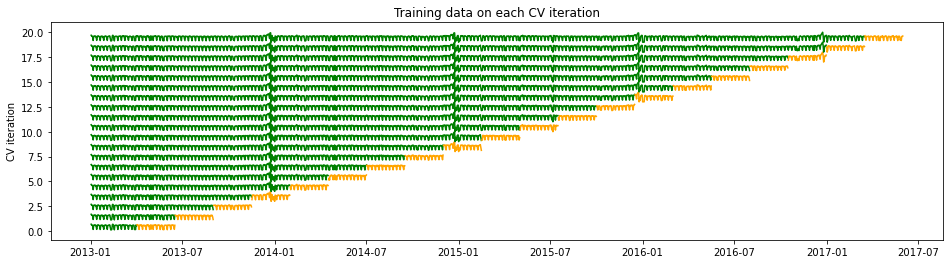

In [16]:
# Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

# Create time-series cross-validation object
cv = TimeSeriesSplit(n_splits=20)

# Iterate through CV splits
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(store_train/store_train.max())):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(store_train.index[tr], ii + store_train.iloc[tr]/store_train.max(), color='green')
    ax.plot(store_train.index[tt], ii + store_train.iloc[tt]/store_train.max(), color='orange')

ax.set(title='Training data on each CV iteration', ylabel='CV iteration')
plt.show()

We're now going to train a model on each green fold and evaluate it on the orange fold. Then we'll plot the MAE for each fold.

In [17]:
X = store_train

# Iterate through CV splits
n_splits = 20
cv = TimeSeriesSplit(n_splits=n_splits)

idx_lst = []
values_lst = []

for ii, (tr, tt) in tqdm(enumerate(cv.split(X))):
    # Fit the model on training data and collect the coefficients
    train = X.iloc[tr]
    test = X.iloc[tt]
    idx_lst.append(X.index[tt][0])
    error_lst = []
    predictions = predict_n_periods(series_=train, 
                    n_periods=len(test), 
                    model=GradientBoostingRegressor(n_estimators=20, learning_rate=0.5), 
                    num_periods_lagged=2,
                    num_periods_diffed=0,
                    weekday=True,
                    month=False,
                    target="customers")
    values_lst.append(mean_absolute_error(test,predictions))

0it [00:00, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

<AxesSubplot:>

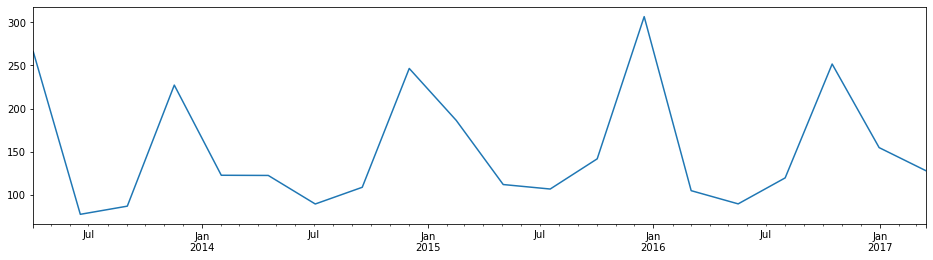

In [18]:
pd.Series(values_lst, index=idx_lst).plot()

The performance of the model is not consistent over time, so this may explain why in the previous BLU the model got better results for test than validation. Maybe the test set was simply an easier fold to predict.

Also interesting to note is that the model performs signifcantly worse on the folds that include the end of the year. Let's plot part of the original time series to understand why:

<AxesSubplot:xlabel='date'>

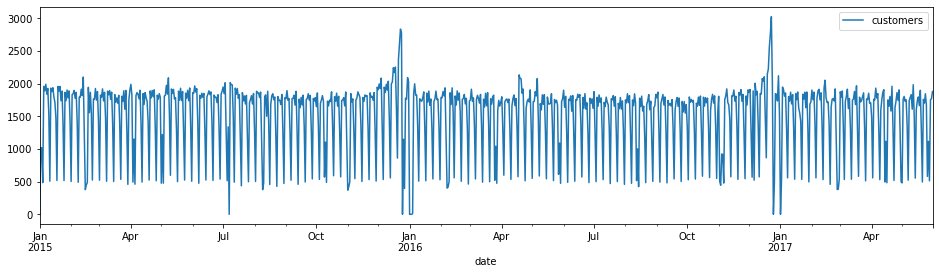

In [19]:
store_train['2015':].plot()

Indeed, it seems that during December the behavior of the time series clearly changes. It's possible that the model may need more features to be able to predict these particular times better. For example, we're only using the day of the week and in some models also the month, but maybe the day of the month could also help. There are always more features to try!

## 2.3 Sliding Window 

Another possible cross validation strategy is using a sliding window instead of an expanding one. This is shown in the plot below, where whe chose the size of the sliding window to be one year. Basically, this makes it so that the fold only uses the last 365 days of data. 

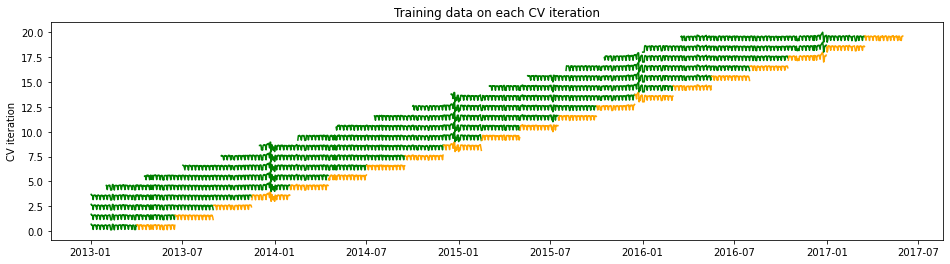

In [20]:
# Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

# Create time-series cross-validation object
cv = TimeSeriesSplit(n_splits=20, max_train_size=365)

# Iterate through CV splits
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(store_train/store_train.max())):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(store_train.index[tr], ii + store_train.iloc[tr]/store_train.max(), color='green')
    ax.plot(store_train.index[tt], ii + store_train.iloc[tt]/store_train.max(), color='orange')

ax.set(title='Training data on each CV iteration', ylabel='CV iteration')
plt.show()

At first it may seem counter-intuitive not to use all available data, but more data doens't always mean better results. Particularly in the world of time series, where many times the processes we're modelling are not stationary. This means that the most recent data may represent the future data better than older data.

In [21]:
X = store_train

# Iterate through CV splits
n_splits = 20
cv = TimeSeriesSplit(n_splits=n_splits, max_train_size=365)

idx_lst = []
values_lst_block = []

for ii, (tr, tt) in tqdm(enumerate(cv.split(X))):
    # Fit the model on training data and collect the coefficients
    train = X.iloc[tr]
    test = X.iloc[tt]
    idx_lst.append(X.index[tt][0])
    error_lst = []
    predictions = predict_n_periods(series_=train, 
                    n_periods=len(test), 
                    model=GradientBoostingRegressor(n_estimators=20, learning_rate=0.5), 
                    num_periods_lagged=2,
                    num_periods_diffed=0,
                    weekday=True,
                    month=False)
    values_lst_block.append(mean_absolute_error(test,predictions))

0it [00:00, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

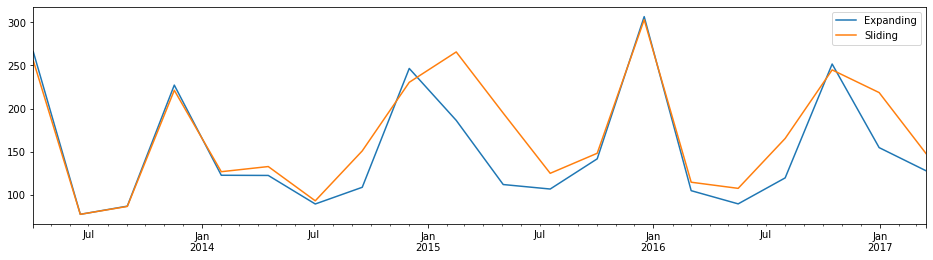

In [22]:
pd.Series(values_lst, index=idx_lst).plot(label='Expanding')
pd.Series(values_lst_block, index=idx_lst).plot(label='Sliding')
plt.legend()

The results are interesting, they seem to indicate that the end of the year still is the most difficult fold to predict when using the sliding window. But they also show that the sliding window most times obtains worse results than the expanding one, which indicates that there is no advantage in reducing the amount of data used to train this model.

For a nice read on the importance of cross validation for time series applications make sure to read [this article]( https://blog.daredata.engineering/on-fmcg-and-retail-forecasting/) from LDSSA instructor Ivo Bernado.

# 3. Measuring Uncertainty

From the previous examples we can understand that there is always some uncertainty in our predictions. In the real world, we are rarely only interested in obtaining the predicted value, we also want to measure the uncertainty that comes with it. For example, the models from the SARIMAX family already had some measure of uncertainty. How can we get this when using machine learning models? A simple way is to train models for the quantile loss. Normally, we train models to converge to the mean of the distribution, but we can also use quantile losses. You may recall from the bootcamp that quantiles are useful for dividing the distribution of data. In the example below use use quantiles 0.05 and 0.95. Intuitively, the first one means that the model will converge to values smaller than 95% of the data. While the second means that the model will converge to values higher than 95% of the data.


An example is given below. 

In [23]:
predictions = predict_n_periods(series_=store_train, 
                  n_periods=len(store_test), 
                  model=GradientBoostingRegressor(n_estimators=50, learning_rate=0.2), 
                  num_periods_lagged=2,
                  num_periods_diffed=0,
                  weekday=True,
                  month=True,
                  rolling=[np.mean,np.min,np.max,np.std],
                  holidays=True
                  )

  0%|          | 0/76 [00:00<?, ?it/s]

In [24]:
predictions_max = predict_n_periods(series_=store_train, 
                  n_periods=len(store_test), 
                  model=GradientBoostingRegressor(loss='quantile',alpha=0.95,n_estimators=50, learning_rate=0.2), 
                  num_periods_lagged=2,
                  num_periods_diffed=0,
                  weekday=True,
                  month=True,
                  rolling=[np.mean,np.min,np.max,np.std],
                  holidays=True
                  )

  0%|          | 0/76 [00:00<?, ?it/s]

In [25]:
predictions_min = predict_n_periods(series_=store_train, 
                  n_periods=len(store_test), 
                  model=GradientBoostingRegressor(loss='quantile',alpha=0.05,n_estimators=50, learning_rate=0.2), 
                  num_periods_lagged=2,
                  num_periods_diffed=0,
                  weekday=True,
                  month=True,
                  rolling=[np.mean,np.min,np.max,np.std],
                  holidays=True
                  )

  0%|          | 0/76 [00:00<?, ?it/s]

In [26]:
mean = pd.Series(predictions, index=store_test.index)
q10 = pd.Series(predictions_min, index=store_test.index)
q90 = pd.Series(predictions_max, index=store_test.index)

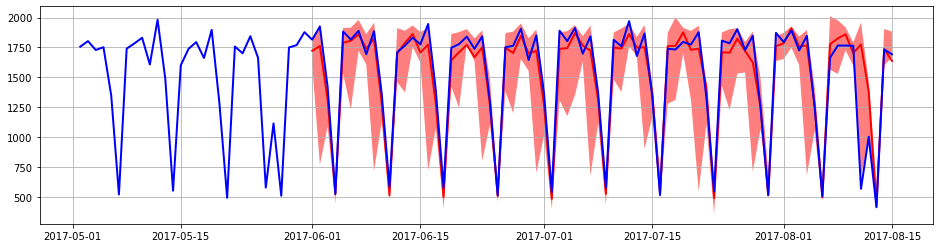

In [27]:
# plot it!
fig, ax = plt.subplots(1)
ax.plot(mean.index, mean.values, lw=2, label='prediction', color='red')
ax.plot(store[1570:].index, store[1570:].values, lw=2, label='true values', color='blue')
ax.fill_between(mean.index, q90, q10, facecolor='red', alpha=0.5)
ax.grid()